In [ ]:
import torch
import sys
import os
current_dir = os.getcwd()

parent_dir = os.path.dirname(current_dir)

sys.path.append(parent_dir)
from retnet import RetNet,RetNetConfig
from Bio import SeqIO
import numpy as np
import itertools
import argparse

#defining model

class ResNet1DBlock(torch.nn.Module):
    def __init__(self, embed_dim, kernel_size=3, bias=False):
        super().__init__()

        self.conv_net = torch.nn.Sequential(
            torch.nn.Conv1d(in_channels=embed_dim, out_channels=embed_dim, kernel_size=1, bias=bias),
            torch.nn.ReLU(),
            torch.nn.Conv1d(in_channels=embed_dim, out_channels=embed_dim, kernel_size=kernel_size, bias=bias, padding="same"),
            torch.nn.ReLU(),
            torch.nn.Conv1d(in_channels=embed_dim, out_channels=embed_dim, kernel_size=1, bias=bias),
            torch.nn.ReLU()
        )
        
    def forward(self, x):
        residual = x

        x = self.conv_net(x)
        x = x + residual

        return x
    
class ResNet1D(torch.nn.Module):
    def __init__(self, embed_dim, num_blocks, kernel_size=3, bias=False):
        super().__init__()

        self.blocks = torch.nn.ModuleList(
            [
                ResNet1DBlock(embed_dim, kernel_size, bias=bias) for _ in range(num_blocks)
            ]
        )

    def forward(self, x):
        for block in self.blocks:
            x = block(x)

        return x   

class ResNet1D_classifier(torch.nn.Module):
    def __init__(self):
        super(ResNet1D_classifier, self).__init__()
        self.linear_in = torch.nn.Linear(384,128)
        self.resnet = ResNet1D(128,16,7, bias=True)
        self.conv_out = torch.nn.Conv1d(128, 1, kernel_size=3, padding="same")
        
    def forward(self, x):
        x = self.linear_in(x)
        x = x.transpose(1,2)
        x = self.conv_out(x)
        x = x.squeeze(1)
        
        return x

class rnaret_lnc_model(torch.nn.Module): 
    def __init__(self, args):
        super(rnaret_lnc_model, self).__init__()
        self.ret = RetNet(args)
        self.classifier = ResNet1D_classifier()

    def forward(self, x): 
        _,aux  = self.ret(x)
        x = aux['inner_states'][-1]
        x = self.classifier(x)
        rttn = aux['rttn'][-1]
        return x, rttn
    
#preparing dataset

class lnc_tokenizer():
    def __init__(self, k, max_len):
        self.k = k
        self.max_len = max_len
        
    def read(self, file_path):
        seqs = []
        seq_lens = []
        cds = []
        des = []
        
        with open(file_path, 'r') as f:
            for record in SeqIO.parse(f, 'fasta'):
                seq = str(record.seq)
                seq = seq[:self.max_len]
                if True:
                    seqs.append(seq)
                    seq_lens.append(len(seq))
                    des.append(record.description)
                    if 'CDS:' not in record.description:
                        cds.append([0,0])
                    else:
                        parts = record.description.split('|')
                        cds_part = next((part for part in parts if part.startswith('CDS:')), None)
                        start, end = map(int, cds_part.split(':')[1].split('-'))
                        cds.append([start-1, end])
                    
        return seqs, cds, seq_lens, des
        
    def tokenize(self, seq):
        kmer_list = np.array([''.join(p) for p in itertools.product('ATCG', repeat=self.k)])
        kmer_to_index = {kmer: idx + 6 for idx, kmer in enumerate(kmer_list)}
        seq = seq.upper()
        seq = seq.replace('U','T')
        seq_len = len(seq)
        
        tokens = np.zeros(self.max_len, dtype=np.int16)
        
        kmers = np.array([seq[i:i+self.k] for i in range(seq_len - self.k + 1)])
        
        indices = np.array([kmer_to_index.get(kmer, 2) for kmer in kmers])
        
        tokens[self.k//2:self.k//2+len(indices)] = indices[:]
        
        tokens[:self.k//2] = 1
        tokens[self.k//2+len(indices):+len(indices)+self.k-1] = 1
        return tokens

class lnc_dataset(torch.utils.data.Dataset):
    def __init__(self, file, k, max_len):
        self.max_len = max_len
        self.tokenizer = lnc_tokenizer(k=k, max_len=max_len)
        self.seqs, self.cds, self.seq_lens, self.des = self.tokenizer.read(file)
        
    def __len__(self):
        return len(self.seqs)

    def __getitem__(self, idx):
        start, end = self.cds[idx]
        raw_seq = self.seqs[idx]
        seq = self.tokenizer.tokenize(self.seqs[idx])
        mask = np.zeros(self.max_len, dtype=np.int16)
        mask[:self.seq_lens[idx]] = 1
        label = np.zeros(self.max_len, dtype=np.int16) 
        label[start:end] = 1
        return seq, label, mask, raw_seq, self.des[idx]
    
class post_process(torch.nn.Module):
    def __init__(self):
        super(post_process, self).__init__()
        
    def forward(self, x, mask):
        with torch.no_grad():
            prob = torch.sigmoid(x) * mask
            seq_prob = prob.unfold(1, 30, 1).mean(dim=2).max(dim=1).values
        return seq_prob


In [ ]:
device = torch.device('cuda:0')

k = 5

model_config = RetNetConfig(
    vocab_size=4**k+6,
    retnet_embed_dim=384,
    retnet_value_embed_dim=512,
    retnet_ffn_embed_dim=512,
    retnet_layers=8,
    retnet_retention_heads=4,
    dropout=0.2,
    activation_dropout=0.2,
    rttn_required = True
)

model = rnaret_lnc_model(model_config)
model.load_state_dict(torch.load(f'../model/lnc/lnc_H_{k}mer.pth'))

model2 = rnaret_lnc_model(model_config)
model2.load_state_dict(torch.load(f'../model/lnc/lnc_M_{k}mer.pth'))
    
model = model.to(device)   

dataset = lnc_dataset('../data/lncRNA_H/test.fa', max_len=3000, k=k)
dataset2 = lnc_dataset('../data/lncRNA_M/test.fa', max_len=3000, k=k)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)
dataloader2 = torch.utils.data.DataLoader(dataset2, batch_size=1, shuffle=False)

/tmp/ipykernel_3512080/313820288.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'../model/lnc/lnc_H_{k}mer.pth'))
/tmp/ipykernel_3512

In [13]:
model.eval()
model2.eval()
with torch.no_grad():
    batch_idx = 0
    for x, y, mask, raw_seq,des in dataloader:
        if batch_idx == 35:
            x = x.to(torch.int32).to(device)
            y = y.to(torch.int32).to(device)
            mask = mask.to(torch.int).to(device)
            prob, rttn = model(x)
            pred = torch.sigmoid(prob) * mask
            avg_rttn = rttn.mean(dim=0)  # [L, L, 4]
            avg_rttn = avg_rttn.mean(dim=0).cpu().numpy()  # [L, L]
            line_rttn = avg_rttn.mean(axis=0)
            seq = raw_seq[0]
            print(des)
            break
        batch_idx = batch_idx + 1

with torch.no_grad():
    batch_idx = 0
    for x, y, mask, raw_seq,des in dataloader:
        if batch_idx == 34:
            x = x.to(torch.int32).to(device)
            y = y.to(torch.int32).to(device)
            mask = mask.to(torch.int).to(device)
            prob, rttn = model(x)
            pred = torch.sigmoid(prob) * mask
            avg_rttn2 = rttn.mean(dim=0)  # [L, L, 4]
            avg_rttn2 = avg_rttn2.mean(dim=0).cpu().numpy()  # [L, L]
            line_rttn2 = avg_rttn2.mean(axis=0)
            seq2 = raw_seq[0]
            print(des)
            break
        batch_idx = batch_idx + 1 
        

('ENST00000403162.7|ENSG00000108588.15|OTTHUMG00000178933.5|OTTHUMT00000444018.1|CCDC47-202|CCDC47|2195|UTR5:1-265|CDS:266-1717|UTR3:1718-2195| pc',)
('ENST00000441152.3|ENSG00000180525.14|OTTHUMG00000017529.5|OTTHUMT00000046386.2|DIP2C-AS1-202|DIP2C-AS1|2251| lnc',)


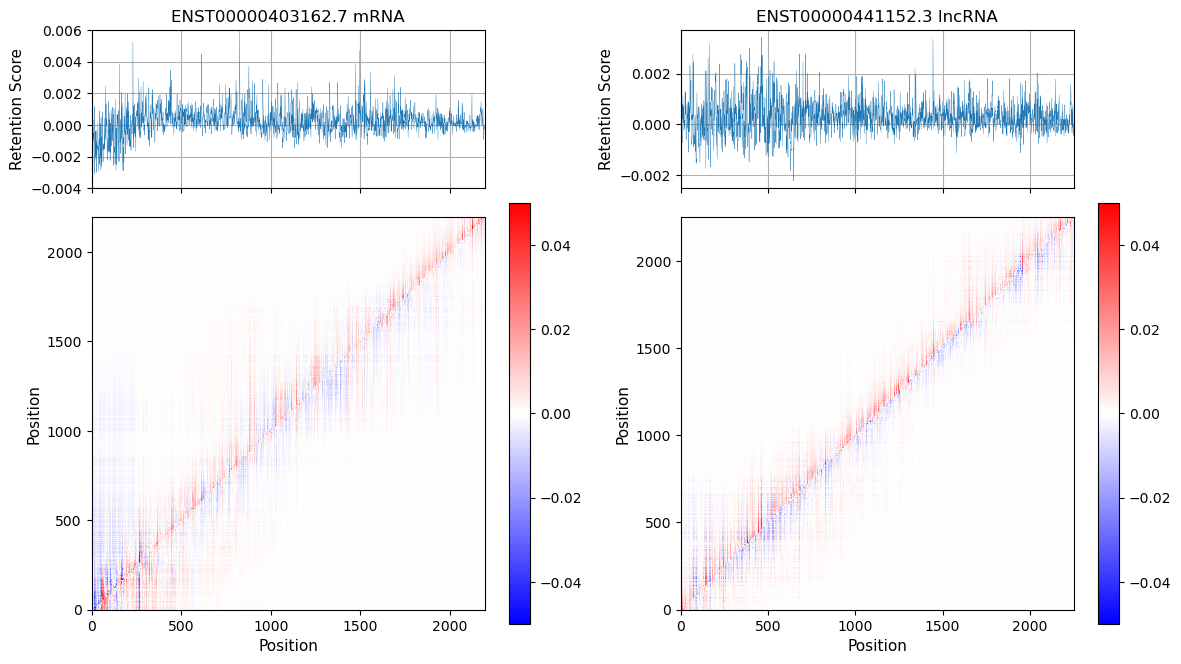

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap, Normalize

pred_np = pred.detach().cpu().numpy().flatten()

x = np.arange(len(pred_np))

fig = plt.figure(figsize=(12, 6.6))  
gs = fig.add_gridspec(2, 2, height_ratios=[1.5, 4])

ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(x, line_rttn, linewidth=0.25)
ax1.set_xlabel('')
ax1.set_ylabel('Retention Score',fontsize=11)
ax1.set_xticklabels([])
ax1.set_xlim(0, len(seq))
ax1.set_ylim(-0.004, 0.006)
ax1.grid(True)
ax1.set_xticks(np.arange(0, len(seq), 500))
ax1.set_title('ENST00000403162.7 mRNA',fontsize=12)

custom_cmap = LinearSegmentedColormap.from_list(
    'custom_cmap',
    ['blue', 'white', 'red'],
    N=256
)

norm = Normalize(vmin=-0.05, vmax=0.05)

ax2 = fig.add_subplot(gs[1, 0])
im_pos = ax2.imshow(avg_rttn, cmap=custom_cmap, norm=norm, interpolation='nearest')

ax2.set_xlabel('Position',fontsize=11)
ax2.set_xlim(0, len(seq))
ax2.set_ylabel('Position',fontsize=11)
ax2.set_ylim(0, len(seq))
ax2.set_yticks(np.arange(0, len(seq), 500))  
ax2.set_xticks(np.arange(0, len(seq), 500))

cbar = fig.colorbar(im_pos, ax=ax2, orientation='vertical')

ax3 = fig.add_subplot(gs[0, 1])
ax3.plot(x, line_rttn2, linewidth=0.25)
ax3.set_xlabel('')
ax3.set_ylabel('Retention Score',fontsize=11)
ax3.set_xticklabels([])
ax3.set_xlim(0, len(seq2))
ax3.set_title('ENST00000441152.3 lncRNA',fontsize=12)
ax3.grid(True)

ax4 = fig.add_subplot(gs[1, 1])
im_pos2 = ax4.imshow(avg_rttn2, cmap=custom_cmap, norm=norm, interpolation='nearest')

ax4.set_xlabel('Position',fontsize=11)
ax4.set_xlim(0, len(seq2))
ax4.set_ylabel('Position',fontsize=11)
ax4.set_ylim(0, len(seq2))
ax4.set_yticks(np.arange(0, len(seq2), 500))

cbar2 = fig.colorbar(im_pos2, ax=ax4, orientation='vertical')

plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, hspace=0.05, wspace=0.2)

pos1 = ax1.get_position()  
pos2 = [pos1.x0, pos1.y0, pos1.width * 0.8, pos1.height]  
ax1.set_position(pos2)  

pos3 = ax3.get_position() 
pos4 = [pos3.x0, pos3.y0, pos3.width * 0.8, pos3.height]  
ax3.set_position(pos4)  

plt.savefig("lnc_heat.pdf", format='pdf', bbox_inches='tight')

In [ ]:
model.eval()
kmer_h_pc = []
kmer_h_lnc = []
codon_h_pc = []
codon_h_lnc = []
kmer_m_pc = []
kmer_m_lnc = []
codon_m_pc = []
codon_m_lnc = []
with torch.amp.autocast(device_type='cuda'):
    with torch.no_grad():
        for x, y, mask, raw_seq, des in dataloader:
            des = des[0]
            x = x.to(torch.int32).to(device)
            y = y.to(torch.int32).to(device)
            mask = mask.to(torch.int).to(device)
            prob, rttn = model(x)
            pred = torch.sigmoid(prob) * mask
            avg_rttn = rttn.mean(dim=0) 
            avg_rttn = avg_rttn.mean(dim=0).cpu().numpy() 
            avg_rttn = avg_rttn.mean(axis=0)
            seq = raw_seq[0]
            avg_rttn = avg_rttn[:len(seq)]
            
            threshold = np.percentile(avg_rttn, 99) 

            high_rttn_indices = np.where(avg_rttn >= threshold)[0]
            for i in high_rttn_indices:
                if 3 < i < len(seq) - 4: 
                    if 'lnc' in des:
                        kmer_h_lnc.append(seq[i-4:i+5])  
                        codon_h_lnc.append(seq[i-1:i+2])  
                    else:
                        kmer_h_pc.append(seq[i-4:i+5])  
                        codon_h_pc.append(seq[i-1:i+2])  
                
model2.eval()
high_rttn_kmers2 = []
with torch.amp.autocast(device_type='cuda'):
    with torch.no_grad():
        for x, y, mask, raw_seq, des in dataloader2:
            des = des[0]
            x = x.to(torch.int32).to(device)
            y = y.to(torch.int32).to(device)
            mask = mask.to(torch.int).to(device)
            prob, rttn = model(x)
            pred = torch.sigmoid(prob) * mask
            avg_rttn = rttn.mean(dim=0)  
            avg_rttn = avg_rttn.mean(dim=0).cpu().numpy()  
            avg_rttn = avg_rttn.mean(axis=0)
            seq = raw_seq[0]
            avg_rttn = avg_rttn[:len(seq)]
            
            threshold = np.percentile(avg_rttn, 99) 

            high_rttn_indices = np.where(avg_rttn >= threshold)[0]
            for i in high_rttn_indices:
                if 3 < i < len(seq) - 4:  
                    if 'lnc' in des:
                        kmer_m_lnc.append(seq[i-4:i+5])  
                        codon_m_lnc.append(seq[i-1:i+2])     
                    else:
                        kmer_m_pc.append(seq[i-4:i+5])  
                        codon_m_pc.append(seq[i-1:i+2])  
         

In [ ]:
import numpy as np
from collections import Counter
import pandas as pd

kmer_h = kmer_h_pc + kmer_h_lnc
kmer_m = kmer_m_pc + kmer_m_lnc
codon_h = codon_h_pc + codon_h_lnc
codon_m = codon_m_pc + codon_m_lnc

kmer_h_count = Counter(kmer_h)
kmer_m_count = Counter(kmer_m)
codon_h_count = Counter(codon_h)
codon_m_count = Counter(codon_m)

codon_df = pd.DataFrame({
    'Codon': list(codon_h_count.keys()),
    'Human Count': list(codon_h_count.values()),
    'Mouse Count': [codon_m_count[codon] for codon in codon_h_count.keys()]
})


codon_df.to_csv('codon_count.csv', index=False)

print("Codon count has been saved to 'codon_count.csv'")


all_codons = set(kmer_h_count.keys()).union(set(kmer_m_count.keys()))

codon_df = pd.DataFrame({
    'Codon': list(all_codons),
    'Human Count': [kmer_h_count.get(codon, 0) for codon in all_codons],
    'Mouse Count': [kmer_m_count.get(codon, 0) for codon in all_codons]
})

# 保存为 CSV 文件
codon_df.to_csv('kmer_count.csv', index=False)

print("Codon count has been saved to 'kmer_count.csv'")

Codon count has been saved to 'codon_count.csv'
Codon count has been saved to 'kmer_count.csv'


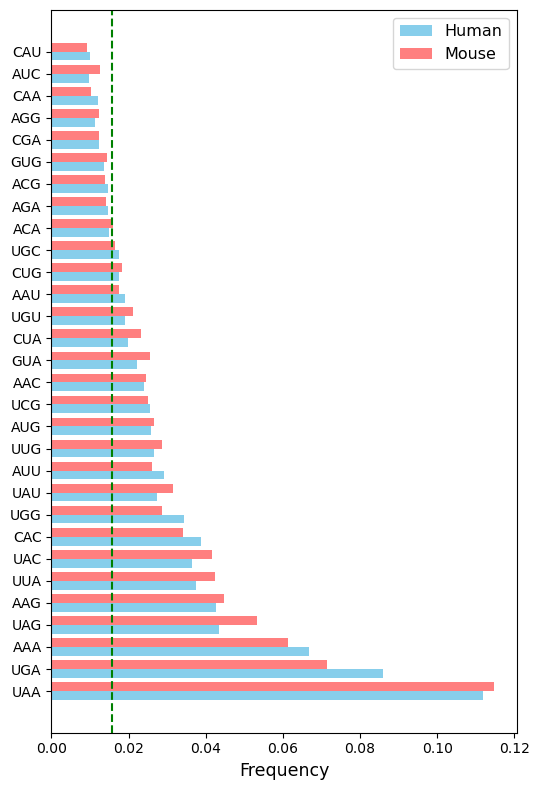

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

codon_h_count = Counter({k.replace('T', 'U'): v for k, v in codon_h_count.items()})
codon_m_count = Counter({k.replace('T', 'U'): v for k, v in codon_m_count.items()})

all_codons = set(codon_h_count.keys()).union(set(codon_m_count.keys()))

sorted_codons = sorted(all_codons, key=lambda codon: codon_h_count[codon] + codon_m_count[codon], reverse=True)[:30]

total_h = sum(codon_h_count.values())
total_m = sum(codon_m_count.values())
frequencies_h = [codon_h_count[codon] / total_h for codon in sorted_codons]
frequencies_m = [codon_m_count[codon] / total_m for codon in sorted_codons]

fig, ax2 = plt.subplots(figsize=(5.5, 8))

y = np.arange(len(sorted_codons))
height = 0.4

ax2.barh(y - height/2, frequencies_h, height, color='skyblue', label='Human')
ax2.barh(y + height/2, frequencies_m, height, color='red', alpha=0.5, label='Mouse')

ax2.axvline(x=1/64, color='green', linestyle='--')

ax2.set_yticks(y)
ax2.set_yticklabels(sorted_codons)
ax2.set_xlabel('Frequency', fontsize=12.5)
ax2.legend(fontsize=11.5)

plt.tight_layout()
plt.savefig("codon.pdf", format='pdf', bbox_inches='tight')

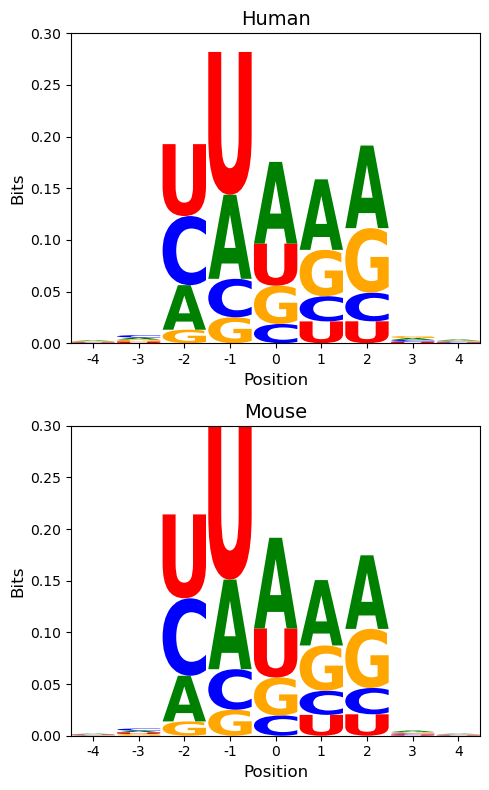

In [ ]:
import logomaker
import pandas as pd

def create_sequence_logo_bits(sequences, ax, title=None):
    seq_len = len(sequences[0])
    bases = ['A', 'C', 'G', 'U']  
    
    counts_matrix = []
    for i in range(seq_len):
        pos_bases = [seq[i] for seq in sequences]

        pos_bases = [base.replace('T', 'U') for base in pos_bases]
        counts = Counter(pos_bases)
        counts_matrix.append([counts.get(base, 0) for base in bases])
    
    df = pd.DataFrame(counts_matrix, columns=bases)
    df = df.div(df.sum(axis=1), axis=0)
    
    information_content = 2 + np.sum(df * np.log2(df.replace(0, 1)), axis=1)
    df_bits = df.multiply(information_content, axis=0)
    
    logo = logomaker.Logo(df_bits,
                         color_scheme='classic',
                         ax=ax)
    
    positions = range(-4, 5)
    ax.set_xticks(range(len(positions)))
    ax.set_xticklabels(positions)
    
    ax.set_xlabel('Position',fontsize=12)
    ax.set_ylabel('Bits',fontsize=12)
    ax.set_ylim(0, 0.3)
    if title:
        ax.set_title(title,fontsize=14)

fig, axes = plt.subplots(2, 1, figsize=(5, 8))

ax1, ax2 = axes.flatten()
create_sequence_logo_bits(kmer_h, ax1, 'Human')
create_sequence_logo_bits(kmer_m, ax2, 'Mouse')

plt.tight_layout()
plt.savefig("motif.pdf", format='pdf', bbox_inches='tight')